# Expected Outputs

## 1. Data uploading step. 
* Explore different techniques to efficiently upload the stochastic process. Choose and implement the technique you want and justify why. For simulation experiments, you may choose the number of samples in the probability distribution you want to consider, we recommend to start with 4. 

<font color=red>
Optional. Advanced exercise. (We recommend to try this after solving the rest of the challenge). Try to encode a Cox-Ingersoll-Ross process into a quantum computer. What about a Heston model?</font> 


<div class="alert alert-block alert-warning">
<b>Hints:</b> 
    
- Read __[The Problem with Grover-Rudolph State Preparation for Quantum Monte-Carlo](https://arxiv.org/abs/2101.02240)__ to understand why efficiently doing this step is important.
    
- __[qGAN](https://www.nature.com/articles/s41534-019-0223-2)__ have been proposed as an alternative promising way of efficiently uploading data.
    
- Read about stochastic processes uploading in __[Quantum-enhanced analysis of discrete stochastic processes](https://www.nature.com/articles/s41534-021-00459-2)__
    
</div>

## Choice of data uploading technique

As demonstrated in the https://arxiv.org/abs/2101.02240 paper, a slow initialization scheme such as Grover-Rudolph state preparation ruins the quantum advantage of Quantum Monte Carlo Integration. Therefore, we use a quantum GAN as demonstrated in https://www.nature.com/articles/s41534-019-0223-2, which can do state initialization in a polynomial amount of gates, allowing us to retain quantum advantage. The use of neural networks does impose an additional computational cost, however this can be amortized if the same probability distribution is used in a large number of simulations, for example when trying to price many options on the same underlying asset.

In [21]:
# define problem

import numpy as np

num_qubits = 4
num_discrete_values = 2**num_qubits

# discretized pdf
S_0 = 50
mu = 0.1 
sigma = 0.2
T = 10
pdf = lambda s : 1/np.sqrt(2*np.pi)*1/(s*sigma*np.sqrt(T))*np.exp(-((np.log(s)-np.log(S_0) - (mu-sigma**2/2)*T))**2/(2*sigma**2*T))
grid_elements = np.linspace(0.1, 250, num_discrete_values)
prob_data = pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

In [22]:
import torch
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal

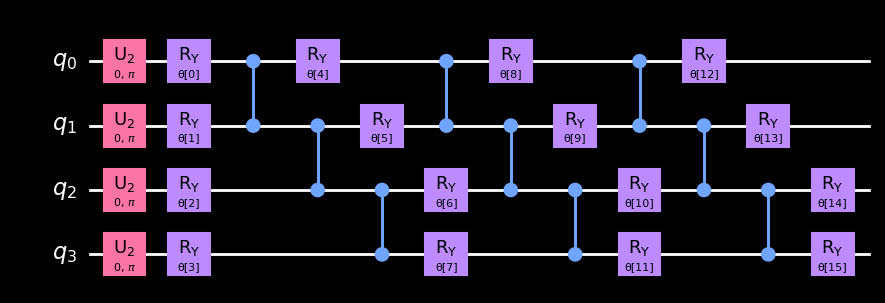

In [67]:
# ansatz adapted from https://www.nature.com/articles/s41534-019-0223-2 and https://qiskit.org/ecosystem/machine-learning/tutorials/04_torch_qgan.html

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = TwoLocal(num_qubits, 'ry', 'cz', 'linear', reps=3)
qc.compose(ansatz, inplace=True)
qc.decompose().draw("mpl",filename="circuit", style = {"backgroundcolor": "black", "linecolor": "white", "gatetextcolor": "white", "gatefacecolor": "white", "textcolor": "white", "subtextcolor": "white"})

In [24]:
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots})

In [25]:
# transform circuit into quantum nn

from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.utils import algorithm_globals

def create_generator():
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

In [26]:
# discriminator

from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

In [27]:
# generate nns

generator = create_generator()
discriminator = Discriminator(1)

In [28]:
# define loss function

def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

In [29]:
# optimizer

from torch.optim import Adam

lr = 0.01  # learning rate
b1 = 0.25*0.7  # first momentum parameter
b2 = 0.25*0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

In [30]:
# visualization

from IPython.display import clear_output

def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

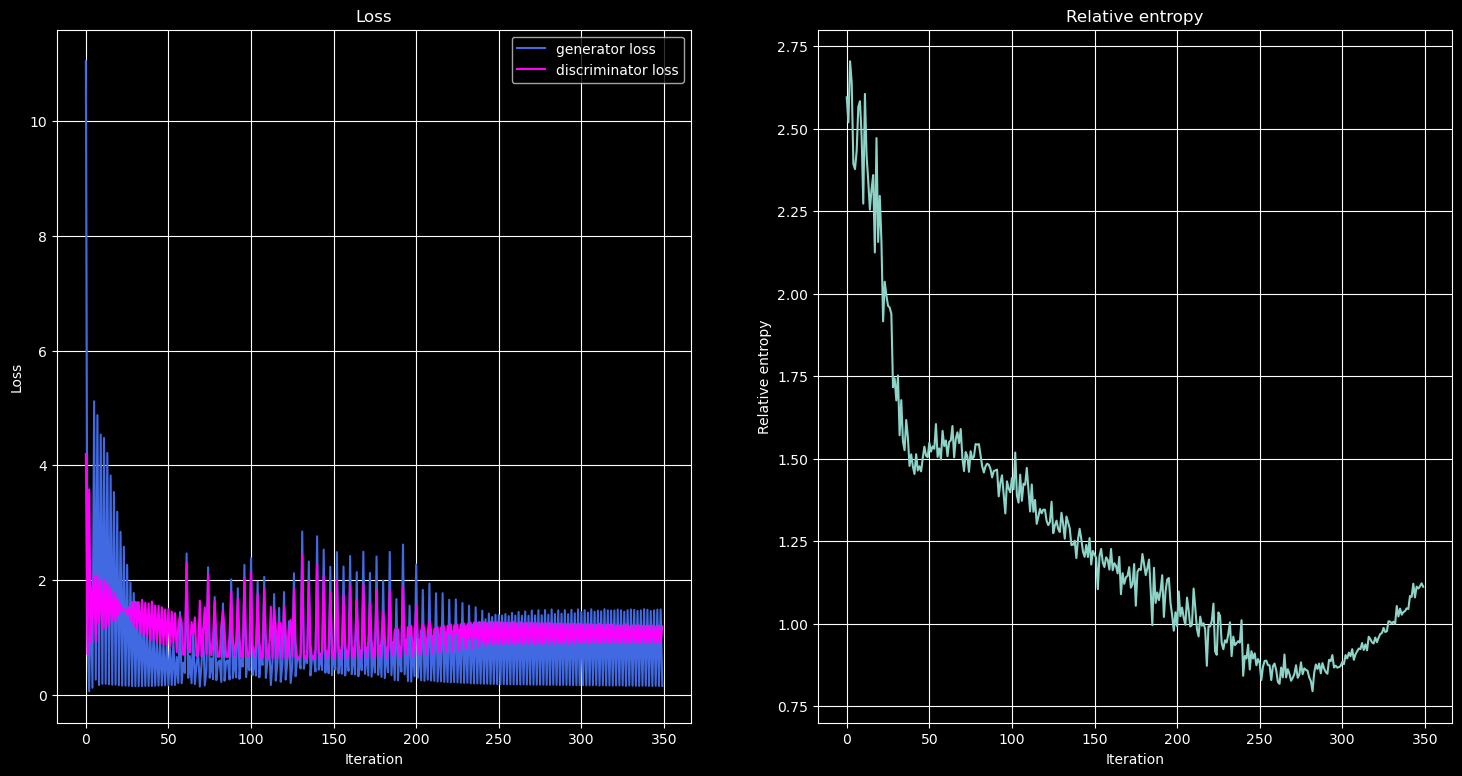

Fit in 948.60 sec


In [52]:
# training

import time
from scipy.stats import entropy

n_epochs = 300

num_qnn_outputs = 2**num_qubits

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements.reshape(-1, 1), dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

## Save Plots

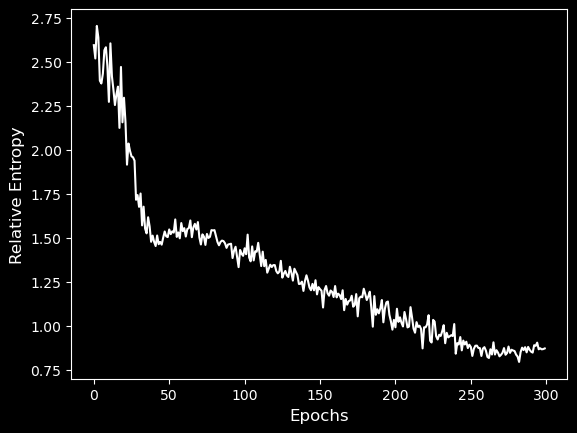

In [50]:
plt.style.use('dark_background')
fig, ax = plt.subplots()

# Add labels and title, adjusting font size
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Relative Entropy', fontsize=12)

# Adjust tick label font size
ax.tick_params(axis='both', which='major', labelsize=10)

ax.plot(entropy_values, color="white")

#plt.savefig("convergence.png", dpi=600)
plt.show()

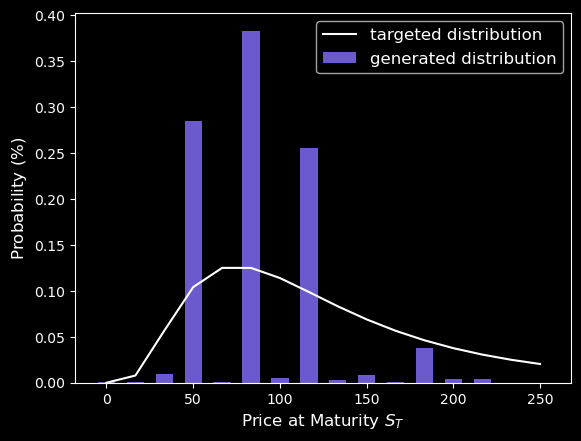

In [51]:
# get probabilities
with torch.no_grad():
    generated_probabilities = generator().numpy()

plt.style.use('dark_background')
fig, ax = plt.subplots()

# Add labels and title, adjusting font size
ax.set_xlabel('Price at Maturity $S_T$', fontsize=12)
ax.set_ylabel('Probability ($\%$)', fontsize=12)


# Adjust tick label font size
ax.tick_params(axis='both', which='major', labelsize=10)
    
ax.bar(grid_elements, generated_probabilities, color="slateblue", width=10, label="generated distribution")
ax.plot(grid_elements, prob_data, color="white", label="targeted distribution")


plt.legend(fontsize=12)
#plt.savefig("qGAN_init.png", dpi=600)
plt.show()

## Optional Exercise
Since the discriminator only needs sampled training data from the stochastic process, using the qGAN for initialization enables us to in principle load an arbitrary stochastic process into a quantum computer, in particular a Cox-Ingersoll-Ross process or a Heston process. In practice, the properties of a specific stochastic process may make training the qGAN challenging.